In [1]:
import os
import sys
import random
import math
import re
import time
import numpy as np
import tensorflow as tf
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Root directory of the project
ROOT_DIR = os.path.abspath("../../")

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn import utils
from mrcnn import visualize
from mrcnn.visualize import display_images
import mrcnn.model as modellib
from mrcnn.model import log

#from samples.cats_dogs import cats_dogs
from samples.miyukiCamera import miyukiCamera

%matplotlib inline 

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")



Using TensorFlow backend.


In [2]:
config = miyukiCamera.MiyukiCameraConfig()
DATA_DIR = "/Users/donchan/Documents/Miyuki/MaskRCNN_data/datasets/miyukiCamera"  #os.path.join(ROOT_DIR, "datasets/cats_dogs")

In [3]:
# Override the training configurations with a few
# changes for inferencing.
class InferenceConfig(config.__class__):
    # Run detection on one image at a time
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

config = InferenceConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.9
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                20
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE         

In [4]:
# Device to load the neural network on.
# Useful if you're training a model on the same 
# machine, in which case use CPU and leave the
# GPU for training.
DEVICE = "/cpu:0"  # /cpu:0 or /gpu:0

# Inspect the model in training or inference modes
# values: 'inference' or 'training'
# TODO: code for 'training' test mode not ready yet
TEST_MODE = "inference"

In [5]:
def get_ax(rows=1, cols=1, size=16):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Adjust the size attribute to control how big to render images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

In [6]:
# Load validation dataset
dataset = miyukiCamera.MiyukiCameraDataset()
dataset.load_classObjects(DATA_DIR, "val")

# Must call before using the dataset
dataset.prepare()

print("Images: {}\nClasses: {}".format(len(dataset.image_ids), dataset.class_names))

/Users/donchan/Documents/Miyuki/MaskRCNN_data/datasets/miyukiCamera/val
Images: 11
Classes: ['BG', 'drug', 'prescription', 'hands', 'sheets', 'money', 'cointab', 'hair']


In [7]:
# Create model in inference mode
with tf.device(DEVICE):
    model = modellib.MaskRCNN(mode="inference", model_dir=MODEL_DIR,
                              config=config)

In [8]:
print(model)

In [10]:


# Or, load the last model you trained
weights_path = model.find_last()

# Load weights
print("Loading weights ", weights_path)
model.load_weights(weights_path, by_name=True)

# loading last model file. /Users/donchan/Documents/Miyuki/Mask_RCNN/logs/miyukicamera20180930T2210/mask_rcnn_miyukicamera_0029.h5
Loading weights  /Users/donchan/Documents/Miyuki/Mask_RCNN/logs/miyukicamera20180930T2210/mask_rcnn_miyukicamera_0029.h5
Re-starting from epoch 29


## image info source  miyukiCamera
# index # 0 polygon
{'name': 'polygon', 'all_points_x': [391, 404, 424, 458, 452, 426, 405, 422, 421, 994, 940, 876, 821, 772, 747, 784, 847, 913, 845, 823, 797, 772, 764, 801, 879, 890, 846, 854, 895, 932, 951, 945, 413, 414, 405, 391, 391, 391, 391, 391, 391, 391], 'all_points_y': [217, 429, 463, 496, 519, 544, 545, 709, 717, 713, 682, 674, 677, 683, 678, 584, 581, 579, 402, 342, 304, 290, 259, 234, 253, 268, 91, 66, 70, 120, 192, 32, 41, 82, 157, 221, 221, 223, 223, 221, 221, 217]}
# index # 1 polygon
{'name': 'polygon', 'all_points_x': [182, 167, 132, 72, 63, 4, 0, 118, 22, 28, 44, 82, 109, 180, 183, 152, 153, 237, 271, 281, 287, 330, 337, 340, 346, 350, 410, 417, 415, 378, 376, 392, 406, 452, 475, 423, 409, 422, 182], 'all_points_y': [665, 563, 517, 420, 403, 338, 256, 334, 137, 101, 79, 80, 137, 254, 248, 39, 32, 34, 237, 242, 240, 134, 106, 70, 39, 33, 31, 64, 143, 278, 306, 370, 431, 496, 518, 552, 556, 668, 665]}
# index # 2 polygon
{'name': 

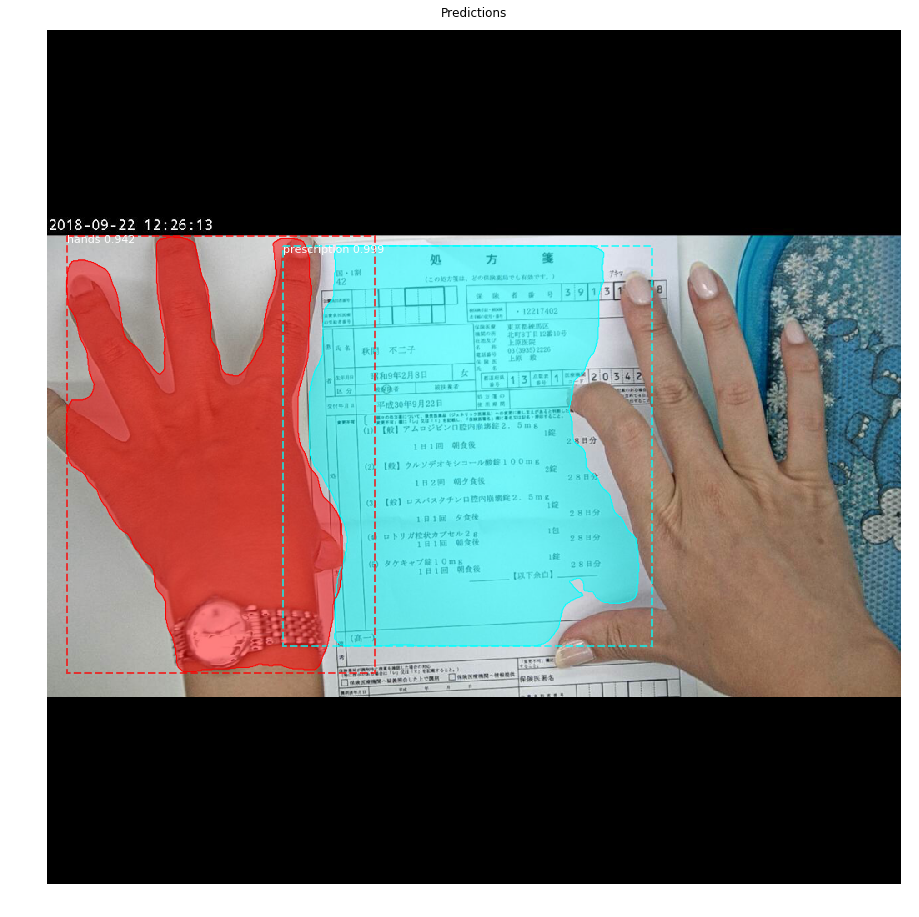

In [16]:
image_id = random.choice(dataset.image_ids)
image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset, config, image_id, use_mini_mask=False)
info = dataset.image_info[image_id]
print("image ID: {}.{} ({}) {}".format(info["source"], info["id"], image_id, 
                                       dataset.image_reference(image_id)))

print(len( [image]  ))

# Run object detection
results = model.detect([image], verbose=1)

# Display results
ax = get_ax(1)
r = results[0]

print("- " * 40 )
print("Scores --> ",  r['scores'])
print("Class Names --> ", [dataset.class_names[i] for i in r['class_ids']] )  

visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
                            dataset.class_names, r['scores'], ax=ax,
                            title="Predictions")
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)